Loading images...
Colon_Adenocarcinoma: 500 images


Loading Colon_Adenocarcinoma: 100%|██████████| 500/500 [00:06<00:00, 78.66it/s] 


Colon_Benign_Tissue: 500 images


Loading Colon_Benign_Tissue: 100%|██████████| 500/500 [00:05<00:00, 83.70it/s] 


Lung_Adenocarcinoma: 500 images


Loading Lung_Adenocarcinoma: 100%|██████████| 500/500 [00:06<00:00, 82.94it/s] 


Lung-Benign_Tissue: 500 images


Loading Lung-Benign_Tissue: 100%|██████████| 500/500 [00:05<00:00, 85.94it/s] 


Lung_Squamous_Cell_Carcinoma: 500 images


Loading Lung_Squamous_Cell_Carcinoma: 100%|██████████| 500/500 [00:05<00:00, 83.81it/s] 



Total images loaded: 2500

Train+Val: 2000, Test: 500
Building MobileNetV2 feature extractor...
Building ResNet50 feature extractor...

Extracting features from all models...
Extracting features with MobileNetV2...
  Feature shape: (2000, 1280)
Extracting features with ResNet50...
  Feature shape: (2000, 2048)
Combined feature shape: (2000, 3328)
Extracting features with MobileNetV2...
  Feature shape: (500, 1280)
Extracting features with ResNet50...
  Feature shape: (500, 2048)
Combined feature shape: (500, 3328)

Applying feature selection...
SelectKBest with ANOVA F-value...
Selected 1000 features using SelectKBest
Recursive Feature Elimination...
Selected 500 features using RFE

Ranking selected features and selecting top N...
Retrieved scores for 1000 selected features.
Selected top 200 features based on F-score ranking for the final model.

Training MLP classifier on selected features...
Iteration 1, loss = 0.30042508
Validation score: 0.945000
Iteration 2, loss = 0.10563046
Val

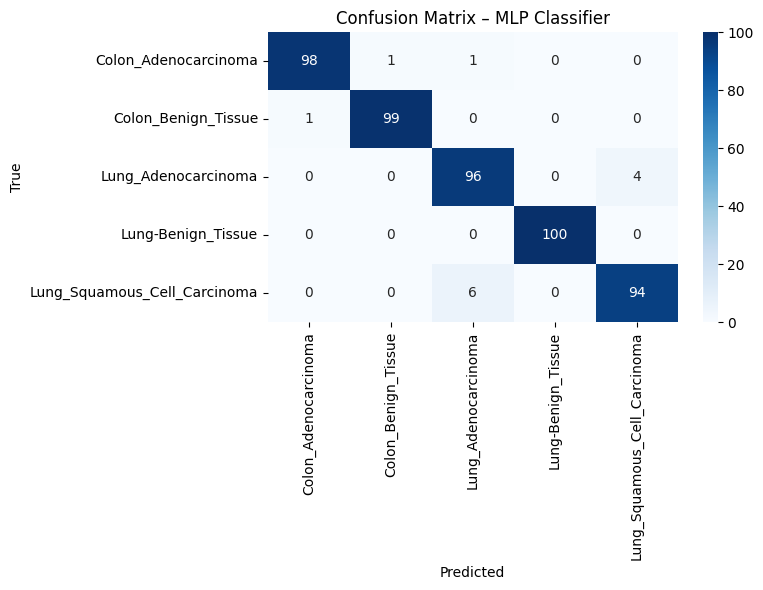

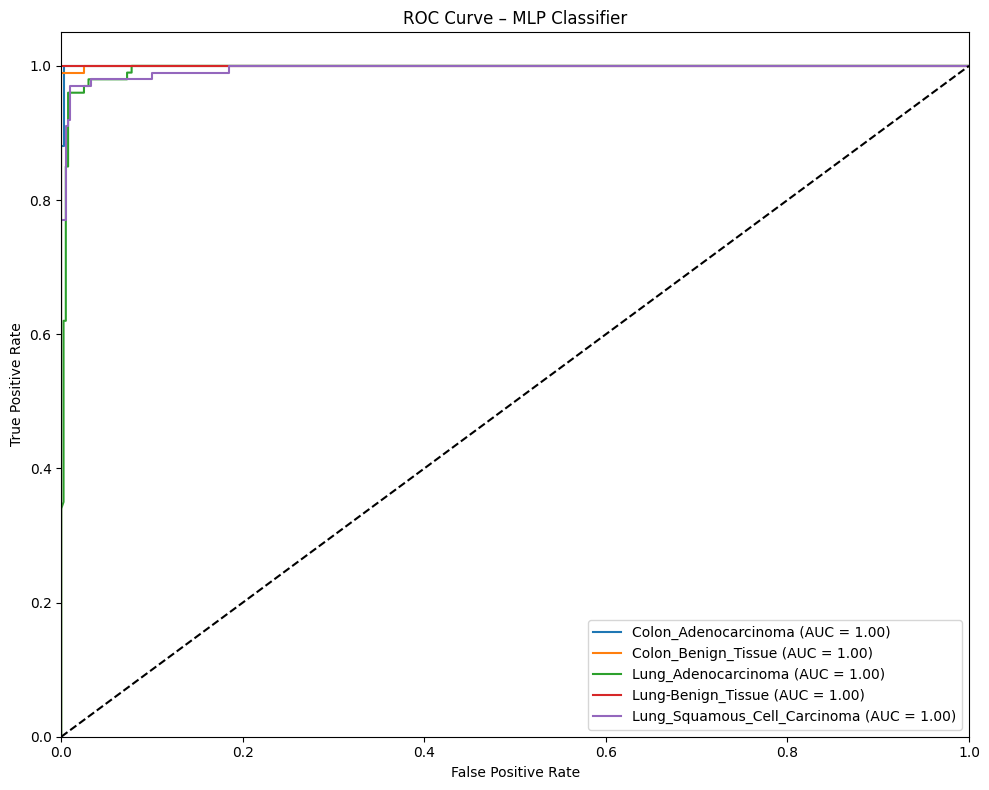

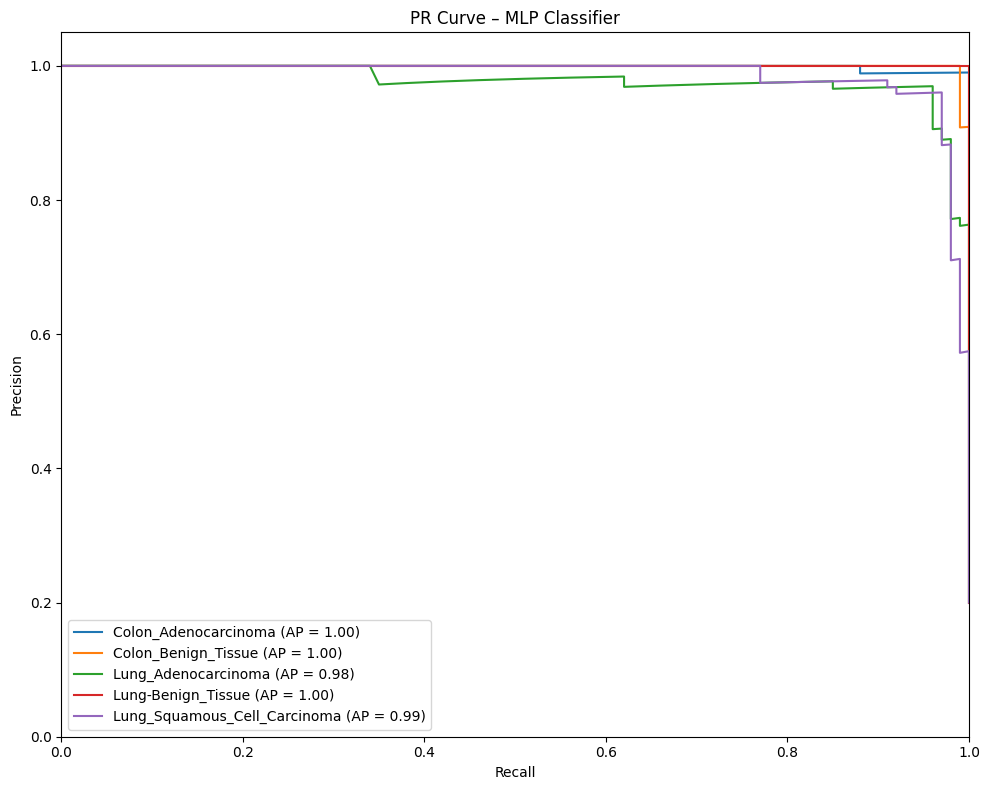


 FINAL SUMMARY
Feature Extraction: MobileNetV2 + ResNet50
Feature Selection: SelectKBest -> F-score Ranking
Classifier: MLP
------------------------------------------------------------
Test Accuracy:       0.9740
Macro F1-Score:      0.9740
Weighted F1-Score:   0.9740


In [3]:
"""
Feature Extraction + Feature Ranking + MLP Classifier for Lung and Colon Cancer Classification

This script:
1. Uses MobileNetV2 and ResNet50 as feature extractors.
2. Combines the extracted features.
3. Applies feature selection techniques (SelectKBest, RFE).
4. Ranks the selected features based on their statistical scores.
5. Trains an MLP classifier on the top-ranked features.
6. Provides a comprehensive evaluation including precision, recall, and F1-score.
"""

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_prep
from tensorflow.keras.applications.resnet50 import preprocess_input as res_prep

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score  # Added new metrics
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import gc
import random

# ------------------------------
# 0. Reproducibility / GPU tweaks
# ------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Prevent GPU OOM on some systems (optional)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# ------------------------------
# 1. CONFIG
# ------------------------------
DATASET_DIR = "/kaggle/input/lung-and-colon-cancer/Lung_and_Colon_Cancer"  # change as needed
IMG_SIZE    = 128
BATCH_SIZE  = 16
RANDOM_STATE = SEED
# SAMPLES_PER_CLASS: target number to read (will use all available if fewer)
SAMPLES_PER_CLASS = 500

CLASS_NAMES = [
    'Colon_Adenocarcinoma',
    'Colon_Benign_Tissue',
    'Lung_Adenocarcinoma',
    'Lung-Benign_Tissue',
    'Lung_Squamous_Cell_Carcinoma'
]
N_CLASSES = len(CLASS_NAMES)
label2idx = {name: i for i, name in enumerate(CLASS_NAMES)}

# ------------------------------
# 2. LOAD IMAGES
# ------------------------------
print("Loading images...")
X, y = [], []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Directory not found: {class_dir}")
    img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(img_files) < SAMPLES_PER_CLASS:
        print(f"Warning: Only {len(img_files)} images in {class_name}, using all available.")
    img_files = img_files[:SAMPLES_PER_CLASS]
    print(f"{class_name}: {len(img_files)} images")
    for img_file in tqdm(img_files, desc=f"Loading {class_name}"):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(label2idx[class_name])

X = np.array(X, dtype="float32")
y = np.array(y, dtype="int32")
print(f"\nTotal images loaded: {len(X)}")
if len(X) == 0:
    raise RuntimeError("No images found - check DATASET_DIR and class folder names.")

# ------------------------------
# 3. TRAIN-TEST SPLIT (80/20, stratified)
# ------------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print(f"\nTrain+Val: {X_train_val.shape[0]}, Test: {X_test.shape[0]}")

# ------------------------------
# 4. FEATURE EXTRACTORS (CORRECTED)
# ------------------------------
def build_feature_extractor(base_fn, preprocess_fn):
    """
    Build a feature extractor model using a pre-trained backbone.
    This version explicitly adds a GlobalAveragePooling2D layer to get a feature vector.
    """
    try:
        base = base_fn(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    except Exception as e:
        print(f"Warning: failed to load pretrained weights: {e}")
        print("Falling back to weights=None (training from scratch).")
        base = base_fn(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    inputs = base.input
    x = base.output
    x = GlobalAveragePooling2D()(x) # Add GAP layer to get a 1D feature vector
    
    feature_extractor = Model(inputs=inputs, outputs=x)
    
    def preprocess(images):
        return preprocess_fn(images)
    
    return feature_extractor, preprocess

# Create feature extractors
feature_extractors = [
    ("MobileNetV2", MobileNetV2, mob_prep),
    ("ResNet50",    ResNet50,    res_prep),
]
extractors = []
for name, base_fn, prep_fn in feature_extractors:
    print(f"Building {name} feature extractor...")
    extractor, preprocess = build_feature_extractor(base_fn, prep_fn)
    extractors.append((name, extractor, preprocess))

# ------------------------------
# 5. EXTRACT FEATURES
# ------------------------------
print("\nExtracting features from all models...")
def extract_features(extractors, images):
    all_features = []
    for name, extractor, preprocess in extractors:
        print(f"Extracting features with {name}...")
        preprocessed = preprocess(images.copy())
        features = extractor.predict(preprocessed, batch_size=BATCH_SIZE, verbose=0)
        print(f"  Feature shape: {features.shape}")
        all_features.append(features)
    
    combined_features = np.concatenate(all_features, axis=1)
    print(f"Combined feature shape: {combined_features.shape}")
    return combined_features

X_train_val_features = extract_features(extractors, X_train_val)
X_test_features = extract_features(extractors, X_test)

# ------------------------------
# 6. FEATURE SELECTION
# ------------------------------
print("\nApplying feature selection...")
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val_features)
X_test_scaled = scaler.transform(X_test_features)

# Method 1: SelectKBest with ANOVA F-value
print("SelectKBest with ANOVA F-value...")
k_best = SelectKBest(f_classif, k=min(1000, X_train_val_scaled.shape[1]))
X_train_val_kbest = k_best.fit_transform(X_train_val_scaled, y_train_val)
X_test_kbest = k_best.transform(X_test_scaled)
print(f"Selected {X_train_val_kbest.shape[1]} features using SelectKBest")

# Method 2: Recursive Feature Elimination with RandomForestClassifier
print("Recursive Feature Elimination...")
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=min(500, X_train_val_scaled.shape[1]), step=0.1)
X_train_val_rfe = rfe.fit_transform(X_train_val_scaled, y_train_val)
X_test_rfe = rfe.transform(X_test_scaled)
print(f"Selected {X_train_val_rfe.shape[1]} features using RFE")

# We will proceed with the features from SelectKBest
X_train_val_selected = X_train_val_kbest
X_test_selected = X_test_kbest

# ------------------------------
# 7. RANK FEATURES AND SELECT TOP N (CORRECTED LOGIC)
# ------------------------------
print("\nRanking selected features and selecting top N...")
selected_feature_scores = k_best.scores_[k_best.get_support(indices=True)]
print(f"Retrieved scores for {len(selected_feature_scores)} selected features.")

top_n = min(200, len(selected_feature_scores))
top_n_indices_in_selected = np.argsort(selected_feature_scores)[-top_n:]

X_train_val_final = X_train_val_selected[:, top_n_indices_in_selected]
X_test_final = X_test_selected[:, top_n_indices_in_selected]
print(f"Selected top {top_n} features based on F-score ranking for the final model.")

# ------------------------------
# 8. TRAIN MLP CLASSIFIER
# ------------------------------
print("\nTraining MLP classifier on selected features...")
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=BATCH_SIZE,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=RANDOM_STATE,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True
)
mlp.fit(X_train_val_final, y_train_val)

# ------------------------------
# 9. EVALUATE THE MODEL (ENHANCED)
# ------------------------------
print("\nEvaluating the MLP classifier...")
y_pred = mlp.predict(X_test_final)
y_proba = mlp.predict_proba(X_test_final)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
# Macro average: Calculate metrics for each label, and find their unweighted mean.
# Weighted average: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Print detailed metrics
print("\n" + "="*40)
print(" DETAILED TEST SET METRICS")
print("="*40)
print(f"Overall Accuracy:         {accuracy:.4f}")
print("-" * 40)
print("Macro-Averaged Metrics (treats all classes equally):")
print(f"  Precision:               {precision_macro:.4f}")
print(f"  Recall:                  {recall_macro:.4f}")
print(f"  F1-Score:                {f1_macro:.4f}")
print("-" * 40)
print("Weighted-Averaged Metrics (accounts for class imbalance):")
print(f"  Precision:               {precision_weighted:.4f}")
print(f"  Recall:                  {recall_weighted:.4f}")
print(f"  F1-Score:                {f1_weighted:.4f}")
print("="*40)

# Classification report (per-class breakdown)
print("\n=== Per-Class Classification Report ===")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix – MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=range(N_CLASSES))
plt.figure(figsize=(10,8))
for i in range(N_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASS_NAMES[i]} (AUC = {roc_auc_i:.2f})')
plt.plot([0,1],[0,1],"k--")
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – MLP Classifier")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10,8))
for i in range(N_CLASSES):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap_i = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'{CLASS_NAMES[i]} (AP = {ap_i:.2f})')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve – MLP Classifier")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# ------------------------------
# 10. FINAL SUMMARY
# ------------------------------
print("\n" + "="*60)
print(" FINAL SUMMARY")
print("="*60)
print(f"Feature Extraction: MobileNetV2 + ResNet50")
print(f"Feature Selection: SelectKBest -> F-score Ranking")
print(f"Classifier: MLP")
print("-" * 60)
print(f"Test Accuracy:       {accuracy:.4f}")
print(f"Macro F1-Score:      {f1_macro:.4f}")
print(f"Weighted F1-Score:   {f1_weighted:.4f}")
print("="*60)